In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [ ]:
from PIL import PngImagePlugin  
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [7]:
topics = [
  'Culture.Biography.Biography*',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'History and Society.Business and economics',
 'History and Society.Education',
 'History and Society.History',
 'History and Society.Military and warfare',
 'History and Society.Politics and government',
 'History and Society.Society',
 'History and Society.Transportation',
 'STEM.Biology',
 'STEM.Chemistry',
 'STEM.Computing',
 'STEM.Earth and environment',
 'STEM.Engineering',
 'STEM.Libraries & Information',
 'STEM.Mathematics',
 'STEM.Medicine & Health',
 'STEM.Physics',
 'STEM.STEM*',
 'STEM.Space',
 'STEM.Technology']

In [9]:
training_set = pd.read_pickle("/dlabdata1/piccardi/WikipediaImageClassification/training_set.pkl")\
            .sample(500000, random_state=0)
training_set['full_path'] = training_set.image_path.apply(lambda r: '/scratch/WIT_Dataset/images'+r)
training_set[['full_path', 'labels']]

,full_path,labels
736437,/scratch/WIT_Dataset/images/5/54/The_Return_of...,"[Geography.Regions.Europe.Europe*, Geography.R..."
20148,/scratch/WIT_Dataset/images/a/a2/PIA20862-Cere...,"[STEM.Space, STEM.STEM*]"
2770647,/scratch/WIT_Dataset/images/f/fa/Grimsby_-_The...,"[Geography.Regions.Europe.Europe*, Geography.R..."
1930902,/scratch/WIT_Dataset/images/9/93/Gisborne_nz_2...,"[Geography.Regions.Oceania, Geography.Geograph..."
1373350,/scratch/WIT_Dataset/images/1/1d/Rear_Admiral_...,"[Geography.Regions.Europe.Europe*, History and..."
...,...,...
3700342,/scratch/WIT_Dataset/images/a/a6/Homme_Castle_...,[History and Society.Military and warfare]
1899595,/scratch/WIT_Dataset/images/b/bb/Dathshead_haw...,"[STEM.Biology, STEM.STEM*]"
3175173,/scratch/WIT_Dataset/images/f/f5/Ahmednagar_fo...,"[Geography.Geographical, Geography.Regions.Asi..."
3475017,/scratch/WIT_Dataset/images/c/c4/Félicien_Chap...,[Culture.Biography.Biography*]


In [10]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

width, height = 64, 64
target_size = (height, width)
print('1')
datagen = ImageDataGenerator(rescale=1./255, 
#                              rotation_range=40, 
#                              width_shift_range=0.2,
#                              height_shift_range=0.2, 
#                              shear_range=0.2,
#                              zoom_range=0.2,
#                              horizontal_flip=True,
#                              fill_mode='nearest'
                             validation_split=0.05, 
                             ) 
print('2')

train_generator = datagen.flow_from_dataframe(
        dataframe=training_set, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='training',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=120,
#         validate_filenames=False, 
        target_size=target_size,
        shuffle=False
        )
print('3')

validation_generator = datagen.flow_from_dataframe(
        dataframe=training_set, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
#         validate_filenames=False, 
        target_size=target_size,
        shuffle=False
        )
print('4')


1
2


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 41468 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 368133 validated image filenames belonging to 41 classes.
3


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 41468 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 19375 validated image filenames belonging to 41 classes.
4


In [11]:
class_indices = train_generator.class_indices

In [12]:
CLASS_LABELS = list(class_indices.keys())

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                       input_shape=(width, height, 3))
efficient_net.trainable = False

model = Sequential([
    efficient_net,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(CLASS_LABELS), activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.nn.sigmoid_cross_entropy_with_logits,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               655488    
_________________________________________________________________
dense_1 (Dense)              (None, 41)                5289      
Total params: 4,710,348
Trainable params: 660,777
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
epochs=15

history = model.fit(
  train_generator,
  verbose=1,
#   steps_per_epoch=15,
  validation_data=validation_generator,
  epochs=epochs,
#   validation_steps=7,
#   workers=2,
#   use_multiprocessing=True,
)

Epoch 1/15
3068/3068 [==============================] - 5412s 2s/step - loss: 0.6932 - accuracy: 0.2635 - val_loss: 0.6931 - val_accuracy: 0.2632
Epoch 2/15
3068/3068 [==============================] - 632s 206ms/step - loss: 0.6931 - accuracy: 0.2643 - val_loss: 0.6931 - val_accuracy: 0.2632
Epoch 3/15
3068/3068 [==============================] - 631s 206ms/step - loss: 0.6931 - accuracy: 0.2643 - val_loss: 0.6931 - val_accuracy: 0.2632
Epoch 4/15
3068/3068 [==============================] - 629s 205ms/step - loss: 0.6931 - accuracy: 0.2643 - val_loss: 0.6931 - val_accuracy: 0.2632
Epoch 5/15
3068/3068 [==============================] - 631s 206ms/step - loss: 0.6931 - accuracy: 0.2643 - val_loss: 0.6931 - val_accuracy: 0.2632
Epoch 6/15
3068/3068 [==============================] - 631s 206ms/step - loss: 0.6931 - accuracy: 0.2643 - val_loss: 0.6931 - val_accuracy: 0.2632
Epoch 7/15
3068/3068 [==============================] - 631s 206ms/step - loss: 0.6931 - accuracy: 0.2643 - val_lo

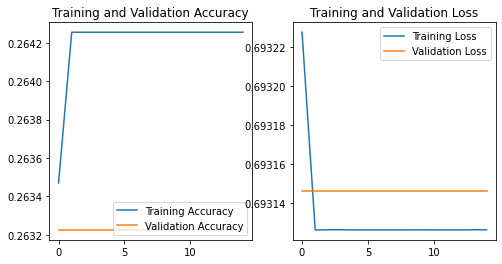

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
model.save('saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/assets
